<a href="https://colab.research.google.com/github/rahiakela/nlp-research-and-practice/blob/main/text-similarity-works/20_keyword_autocomplete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Autocomplete

In [ ]:
!pip install sentence_transformers
!pip install nmslib

In [ ]:
!pip install nmslib

In [4]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import util as STutil

import spacy
from spacy.matcher import Matcher

import nmslib

from plotnine import *

import pandas as pd
import pickle
import json
import tqdm
from IPython.display import display,HTML
pd.set_option('display.max_rows', 1000)

##Load Dataset

In [6]:
keywords_df = pd.read_csv('synid_and_keywords_impairment_v5.csv')
print(len(keywords_df))

11576


In [7]:
keywords_df.head()

,SynId,Short_Description
0,KW10356,0157:H7
1,KW19728,1-25 Dihydroxy
2,KW19729,25 Hydroxy
3,KW19730,25 OH D
4,KW19753,A1C


##Build Vocabulary

In [12]:
concepts_pickle_path = "concepts.pickle"
labels_pickle_path = "labels.pickle"

In [15]:
nlp = spacy.load('en_core_web_sm')

def normalize(span):
    #normalizes a noun or verb phrase
    return ' '.join([tok.lemma_.lower() for tok in span])

def yield_tuple(df, column, total=100):
    #yields a spacy nlp.pipe compliant tuple of the column text values and its dataframe row as the context
    for idx, row in df.iterrows():
        if idx < total:
            yield (row[column], idx)

def get_concepts(df, total=None, load_from_cache=True):

    if load_from_cache:
        with open(concepts_pickle_path,'rb') as fd:
            concepts = pickle.load(fd)
        with open(labels_pickle_path,'rb') as fd:
            labels = pickle.load(fd)
        return concepts, labels

    #Setting load_from_cache to False will bring you here
    print('Extracting concepts. This could take a while. Take a break and stretch :)')

    #You can limit the number of rows processed by passing in total (an integer)
    if not total:
        total = len(df)

    #Get all the noun and verb phrases in the content
    phrases = [] #All the normalized noun/verb phrases ("concepts") in the corpus
    sources = [] #The original text labels that was normalized to the concept

    #Use the spacy matcher to chunk patterns into concept labels
    #We don't need a full taxonomy graph extraction, just a vocabulary with term frequencies
    matcher = Matcher(nlp.vocab)
    nountags = ['NN','NNP','NNS','NOUN'] #Nouns
    verbtags = ['VB','VBD','VBG','VBN','VBP','VBZ','VERB'] #Verbs
    matcher.add("noun_phrases", [[{"TAG":{"IN": nountags}, "IS_ALPHA": True,"OP":"+"}]])
    matcher.add("verb_phrases", [[{"TAG":{"IN": verbtags}, "IS_ALPHA": True,"OP":"+", "LEMMA":{"NOT_IN":["be"]}}]])
    for doc, idx in tqdm.tqdm(nlp.pipe(yield_tuple(df, "Short_Description", total=total), batch_size=40, n_process=4, as_tuples=True), total=total):
        text = doc.text
        matches = matcher(doc)
        for matchid, start, end in matches:
            span = doc[start:end]
            phrases.append(normalize(span))
            sources.append(span.text)


    #Aggregate the normalized concepts by term frequency
    concepts = {}
    labels = {}
    for i in range(len(phrases)):
        phrase = phrases[i]
        if phrase not in concepts:
            concepts[phrase] = 0
            labels[phrase] = sources[i]
        concepts[phrase] += 1

    sorted_concepts = {k: v for k, v in sorted(concepts.items(), key=lambda item: item[1], reverse=True)}

    with open(concepts_pickle_path, 'wb') as fd:
        pickle.dump(sorted_concepts, fd)
    with open(labels_pickle_path, 'wb') as fd:
        pickle.dump(labels, fd)

    return sorted_concepts, labels

What are the concepts with the highest frequency?

In [48]:
# let's do examining the vocabulary
concepts, labels = get_concepts(keywords_df, load_from_cache=False)
top_cons = {k: v for (k, v) in concepts.items() if v > 0}

print(f"Total number of labels: {len(labels.keys())}")
print(f"Total number of concepts: {len(concepts.keys())}")
print(f"Concepts with greater than 0 term frequency: {len(top_cons.keys())}")

Extracting concepts. This could take a while. Take a break and stretch :)


100%|██████████| 11576/11576 [00:42<00:00, 270.56it/s]


Total number of labels: 12808
Total number of concepts: 12808
Concepts with greater than 0 term frequency: 12808


In [49]:
json.dumps(top_cons, indent=2)

'{\n  "hydrochloride": 250,\n  "syndrome": 208,\n  "disease": 206,\n  "sodium": 115,\n  "neoplasm": 106,\n  "mg": 90,\n  "cancer": 81,\n  "cell": 77,\n  "disorder": 69,\n  "hr": 67,\n  "acid": 67,\n  "injury": 66,\n  "fever": 63,\n  "surgery": 62,\n  "acute": 60,\n  "leukemia": 57,\n  "infection": 57,\n  "tumor": 54,\n  "antibody": 50,\n  "pain": 48,\n  "b": 47,\n  "valve": 47,\n  "liver": 46,\n  "blood": 45,\n  "score": 44,\n  "sulfate": 44,\n  "oral": 44,\n  "heart": 42,\n  "urine": 41,\n  "ml": 41,\n  "kidney": 40,\n  "test": 39,\n  "d": 38,\n  "dm": 38,\n  "acetate": 38,\n  "breast": 37,\n  "anemia": 37,\n  "fracture": 37,\n  "calcium": 36,\n  "c": 35,\n  "deficiency": 35,\n  "chloride": 35,\n  "stage": 34,\n  "thyroid": 34,\n  "tablet": 34,\n  "phenylephrine": 33,\n  "potassium": 32,\n  "oral tablet": 32,\n  "hepatitis": 31,\n  "hydrochlorothiazide": 31,\n  "factor": 30,\n  "release": 30,\n  "product": 30,\n  "type": 29,\n  "eye": 29,\n  "artery": 29,\n  "brain": 29,\n  "virus": 2

In [76]:
print(len(concepts))
concepts

12808


{'hydrochloride': 250,
 'syndrome': 208,
 'disease': 206,
 'sodium': 115,
 'neoplasm': 106,
 'mg': 90,
 'cancer': 81,
 'cell': 77,
 'disorder': 69,
 'hr': 67,
 'acid': 67,
 'injury': 66,
 'fever': 63,
 'surgery': 62,
 'acute': 60,
 'leukemia': 57,
 'infection': 57,
 'tumor': 54,
 'antibody': 50,
 'pain': 48,
 'b': 47,
 'valve': 47,
 'liver': 46,
 'blood': 45,
 'score': 44,
 'sulfate': 44,
 'oral': 44,
 'heart': 42,
 'urine': 41,
 'ml': 41,
 'kidney': 40,
 'test': 39,
 'd': 38,
 'dm': 38,
 'acetate': 38,
 'breast': 37,
 'anemia': 37,
 'fracture': 37,
 'calcium': 36,
 'c': 35,
 'deficiency': 35,
 'chloride': 35,
 'stage': 34,
 'thyroid': 34,
 'tablet': 34,
 'phenylephrine': 33,
 'potassium': 32,
 'oral tablet': 32,
 'hepatitis': 31,
 'hydrochlorothiazide': 31,
 'factor': 30,
 'release': 30,
 'product': 30,
 'type': 29,
 'eye': 29,
 'artery': 29,
 'brain': 29,
 'virus': 29,
 'hc': 29,
 't': 28,
 'protein': 28,
 'anti': 28,
 'extended': 28,
 'extended release': 28,
 'carcinoma': 27,
 'seru

In [77]:
print(len(labels))
labels

12808


{'dihydroxy': 'Dihydroxy',
 'hydroxy': 'Hydroxy',
 'oh': 'OH',
 'oh d': 'OH D',
 'd': 'D',
 'aa': 'AA',
 'acth': 'ACTH',
 'adpkd': 'ADPKD',
 'ael': 'AEL',
 'af': 'AF',
 'a': 'A',
 'afld': 'AFLD',
 'afp': 'AFP',
 'ag': 'AG',
 'agap': 'AGAP',
 'agb': 'AGB',
 'ah': 'AH',
 'aids': 'AIDS',
 'ain': 'AIN',
 'ald': 'ALD',
 'alp': 'ALP',
 'als': 'ALS',
 'alt': 'ALT',
 'amd': 'AMD',
 'aml': 'AML',
 'amps': 'AMPS',
 'ana': 'ANA',
 'anll': 'ANLL',
 'apkd': 'APKD',
 'apoe': 'ApoE',
 'appt': 'Appt',
 'arvc': 'ARVC',
 'asa': 'ASA',
 'asap': 'ASAP',
 'ascus': 'ASCUS',
 'ascush': 'ASCUSH',
 'asd': 'ASD',
 'ast': 'AST',
 'bac': 'BAC',
 'b': 'B',
 'cll': 'CLL',
 'bi': 'BI',
 'rads': 'RADS',
 'blood': 'blood',
 'blood urea': 'blood urea',
 'urea': 'urea',
 'blood urea nitrogen': 'blood urea nitrogen',
 'urea nitrogen': 'urea nitrogen',
 'nitrogen': 'nitrogen',
 'bmi': 'BMI',
 'bmp': 'BMP',
 'boop': 'BOOP',
 'bp': 'BP',
 'bph': 'BPH',
 'pll': 'PLL',
 'bun': 'BUN',
 'buncr': 'BUNCr',
 'diff': 'Diff',
 'ca':

##Loading model

In [ ]:
stsb = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")

In [19]:
print(stsb)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': True}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)


##Getting Embeddings

In [20]:
embeddings_pickle_path = "keywords_embeddings.pickle"

In [52]:
def get_embeddings(concepts, minimum_frequency, load_from_cache=True):
  phrases = [key for (key, tf) in concepts.items() if tf >= minimum_frequency]

  if not load_from_cache:
    embeddings = stsb.encode(phrases, convert_to_tensor=True)
    with open(embeddings_pickle_path, "wb") as fd:
      pickle.dump(embeddings, fd)
  else:
    with open(embeddings_pickle_path, "rb") as fd:
      embeddings = pickle.load(fd)
  return phrases, embeddings

In [53]:
# Note!  This is a hyperparameter.
# We are ignoring terms that occur less than this numner in the entire corpus.
# Lowering this number may lower precision
# Raising this number may lower recall
minimum_frequency = 1

In [54]:
# set load_from_cache=False to regenerate the embeddings rather than loading from pickle
phrases, embeddings = get_embeddings(concepts, minimum_frequency, load_from_cache=False)

print(f"Number of embeddings: {len(embeddings)}")
print(f"Dimensions per embedding: {len(embeddings[0])}")

Number of embeddings: 12808
Dimensions per embedding: 768


##Calculate similarity

In [60]:
# let's find the pairs with the highest cosine similarity scores
similarities = STutil.pytorch_cos_sim(embeddings[0:20], embeddings[0:20])
print(f"The shape of the resulting similarities: {similarities.shape}")

The shape of the resulting similarities: torch.Size([20, 20])


In [61]:
a_phrases = []
b_phrases = []
scores = []

for a in range(len(similarities) - 1):
  for b in range(a + 1, len(similarities)):
    a_phrases.append(phrases[a])
    b_phrases.append(phrases[b])
    scores.append(float(similarities[a][b]))

comparisons_df = pd.DataFrame({"phrase a": a_phrases, "phrase b": b_phrases, "score": scores, "name": "similarity"})
comparisons_df = comparisons_df.sort_values(by=["score"], ascending=False, ignore_index=True)
comparisons_df["idx"] = range(len(comparisons_df))
comparisons_df[comparisons_df["score"] > .7]

,phrase a,phrase b,score,name,idx


##Similarity distribution

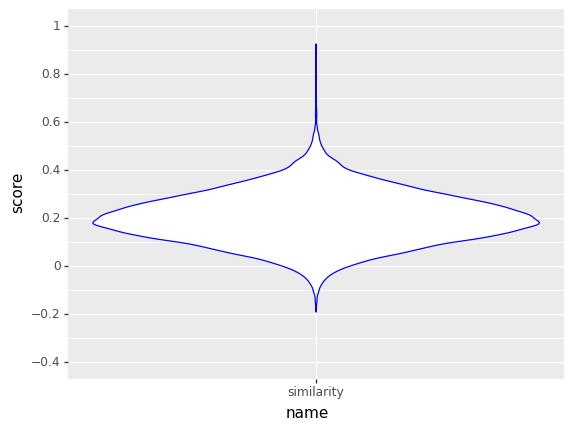

{<ggplot: (8319867013226)>}

In [ ]:
# let’s look at the distribution of the resulting similarity scores
{
    ggplot(comparisons_df[:50000], aes("name", "score"))
    + geom_violin(color="blue")
    + scale_y_continuous(limits=[-0.4,1.0], breaks=[-0.4,-0.2,0,0.2,0.4,0.6,0.8,1.0])
}

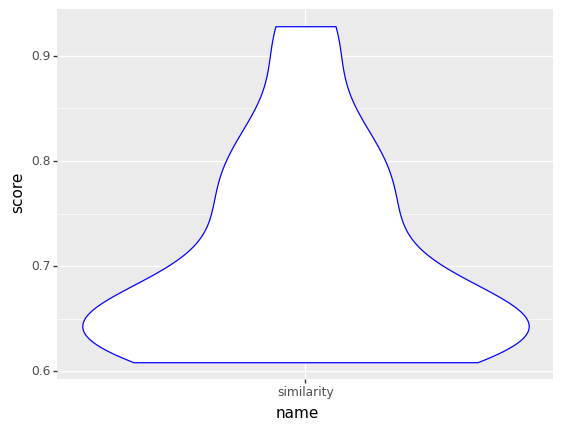

{<ggplot: (8319864579796)>}

In [ ]:
# let’s look at the distribution of the resulting similarity scores
candidate_synonyms = comparisons_df[comparisons_df["score"] > 0.6]
{
    ggplot(candidate_synonyms, aes("name", "score"))
    + geom_violin(color="blue")
}

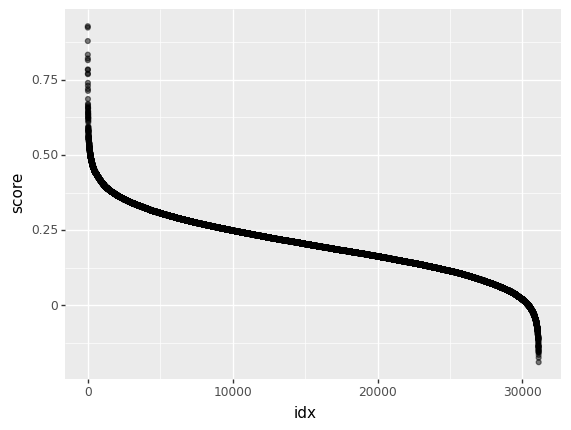

{<ggplot: (8319864618348)>}

In [ ]:
{
    ggplot(comparisons_df, aes("idx", "score"))
    + geom_point(alpha=.5)
}

##Nearest-Neighbor search

In [57]:
embeddings = embeddings.cpu().numpy()

In [58]:
# let's create HNSW index from all 12,375 embeddings and then performs an example search for concepts similar to the term 'bag'

# initialize a new index, using a HNSW index on Cosine Similarity
index = nmslib.init(method="hnsw", space="cosinesimil")
index.addDataPointBatch(embeddings)
index.createIndex(print_progress=True)

# Example query for the new index.  The 25th embedding is the term 'bag'
ids, distances = index.knnQuery(embeddings[25], k=10)
matches = [labels[phrases[idx]].lower() for idx in ids]
print(matches)

['sulfate', 'sulfonate', 'sulfonated', 'sulfur', 'sulfide', 'thiosulfate', 'sulfuric', 'sulfoam', 'subsulfate', 'sulfiram']


In [62]:
# Example query for the new index.  The 21th embedding is the term 'work'
ids, distances = index.knnQuery(embeddings[21], k=10)
matches = [labels[phrases[idx]].lower() for idx in ids]
print(matches)

['valve', 'valve disorder', 'valu', 'valgus', 'valley', 'valve insufficiency', 'valstar', 'valve sclerosis', 'vulva', 'valve regurgitation']


In [63]:
# let's create a method that accepts any query whether or not it’s already in our dictionary
def semantic_suggest(query, k=20):
  matches = []
  embeddings = stsb.encode([query], convert_to_tensor=True)
  ids, distances = index.knnQuery(embeddings[0].cpu().numpy(), k=k)
  for id in range(len(ids)):
    text = phrases[ids[id]]
    distance = 1.0 - distances[id]
    if distance > 0.75:
      matches.append((text, distance))
  if not len(matches):
    matches.append((phrases[ids[1]], 1.0 - distances[1]))
  return matches

In [64]:
#from IPython.display import display,HTML

def print_labels(prefix,matches):
  display(HTML('<h4>Results for: <em>'+prefix+'</em></h4>'))
  for l,d in matches:
    if l in labels.keys():
      l = labels[l].lower()
    print(l + '\t' + str(d))

def autocomplete(prefix):
  matches = semantic_suggest(prefix)
  print_labels(prefix, matches)

In [65]:
autocomplete("COVID")

covid	0.9999998807907104
cidofovir	0.837912380695343


In [66]:
autocomplete("Hyper")

hyper	1.0
hyperhep	0.873988926410675
hyperrab	0.8361355066299438
hyperhep b	0.8310981392860413
hyperrho	0.8256748914718628
hyperfunction	0.8014129400253296
hyperthecosis	0.7986707091331482
hypercare	0.7638525366783142


In [67]:
autocomplete("sporadic") # not present

seroma	0.5637519955635071


In [68]:
autocomplete("lymphadenopathy")

lymphadenopathy	1.0


In [70]:
autocomplete("lymphadeno")

lymphadenopathy	0.6924315690994263


In [71]:
autocomplete("hyperlipidemia")

hyperlipidemia	1.0
lipemia	0.8450582027435303
dyslipidemia	0.8246062994003296
lipid	0.7687883377075195


In [74]:
autocomplete("hyperlipid")

hyperlipidemia	0.9204285740852356
lipid	0.8423225283622742
lipid a	0.8211883902549744
lipid panel	0.8018956184387207
lipitor	0.8002887964248657
liposome	0.7902131676673889
lipemia	0.7839533090591431
microlipid	0.7777470350265503
lipase	0.7682067155838013
lip	0.7670539617538452
liposomal	0.7646543383598328


In [72]:
autocomplete("lipidemia")

lipemia	0.9388076066970825
dyslipidemia	0.916890561580658
hyperlipidemia	0.8742601871490479
lipid	0.8737336993217468
lipid a	0.8265292048454285
lip	0.8100277781486511
lipase	0.7851434946060181
lipid panel	0.7715276479721069


In [73]:
autocomplete("CVD")

cvd	1.0
mvd	0.8492105007171631
cvd risk	0.7880464196205139


##Vector Space Visualization

In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

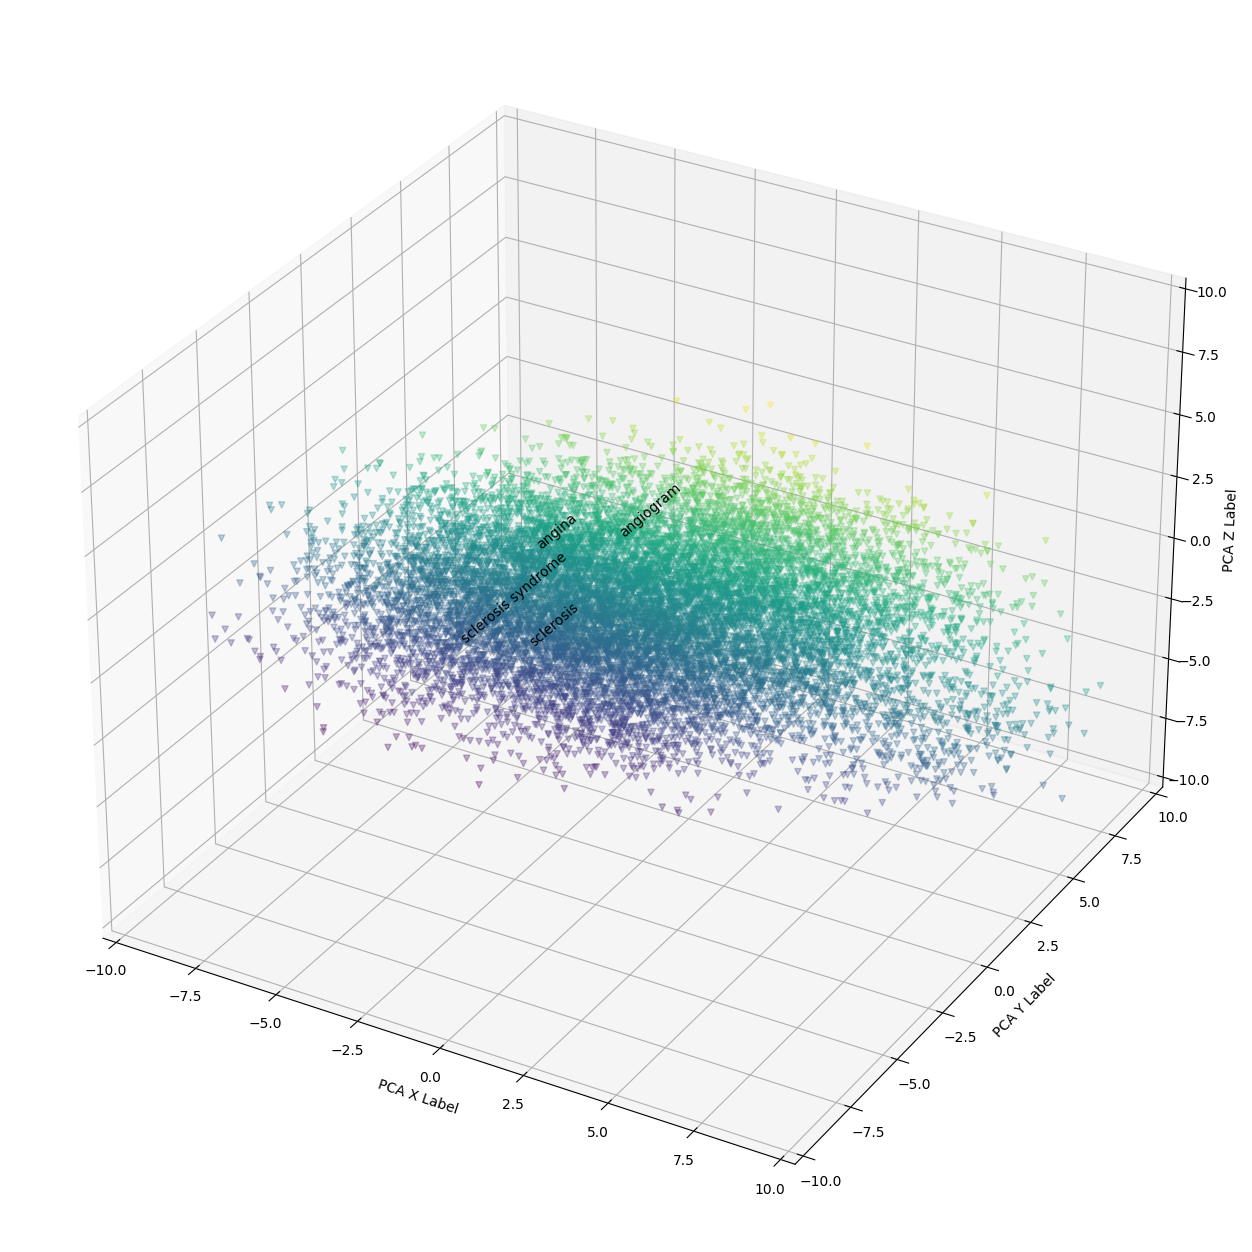

In [75]:
vectors = embeddings
pca = PCA(n_components=3)
pca_data = pca.fit_transform(vectors)

label_ids = []
label_texts = []
ids,_ = index.knnQuery(embeddings[100], k=2)
label_ids += [idx for idx in ids]
ids,_ = index.knnQuery(embeddings[505], k=2)
label_ids += [idx for idx in ids]
label_texts += [labels[phrases[idx]].lower() for idx in label_ids]
markers = ['v']*len(vectors)

components = pd.DataFrame({
    'x': pca_data[:,0],
    'y': pca_data[:,1],
    'z': pca_data[:,2]
})

fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    components['x'].values,
    components['y'].values,
    c=components['y'].values,
    marker='v',
    alpha=0.3
)

for i,label in zip(label_ids,label_texts):
    x = components['x'][i]
    y = components['y'][i]
    z = components['z'][i]
    zdir = 'y'
    ax.text(x, y, z, label, zdir)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_xlabel('PCA X Label')
ax.set_ylabel('PCA Y Label')
ax.set_zlabel('PCA Z Label')
plt.show()